# URL Classification with Support Vector Machine (SVM)
This notebook implements URL classification (malicious URL detection) using SVM algorithm.
It includes comprehensive feature engineering, feature scaling, and model evaluation.

## 1. Import Libraries

In [259]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from tld import get_tld
import os.path
from googlesearch import search
from joblib import Parallel, delayed

# ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix
import joblib
from wordcloud import WordCloud

# Cross validation
from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# Cuda core
# from thundersvm import SVC as ThunderSVC

# import warnings
# warnings.filterwarnings('ignore')

# CONFIG

TOTAL_SAMPLE_SIZE = 5000 # Load some
# TOTAL_SAMPLE_SIZE = -1 # Load all
MALICIOUS_PERCENT = 0.30 
BENIGN_PERCENT = 0.70

RANDOME_STATE = 42

SVM_MODEL = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=RANDOME_STATE
)

APP_NAME='Malsy Gate'

# Data
DATA_PATH = "../artifacts/dataset_cleanup/data_cleaned.csv"
DATA_OUTPUT = "../artifacts/dataset_extraction"

ATTATCH_PATH="../code/attatch"

MATRICS_PATH="../code/exports/matrics"
MODEL_PATH="../code/exports/models"
LABLE_PATH="../code/exports/labels"

## 2. Load Dataset

### Load all of record

In [260]:
# Load all of record from the Dataset
# df = pd.read_csv(DATA_PATH, nrows=500)

# print(f"Dataset shape: {df.shape}")
# print(f"\nDataset columns: {df.columns.tolist()}")
# print(f"\nDataset head:")

# df.head()

### Load some

In [261]:
def load_and_sample_data(file_path, total_size=TOTAL_SAMPLE_SIZE, malicious_ratio=MALICIOUS_PERCENT, random_state=RANDOME_STATE):
    try:
        df_full = pd.read_csv(file_path)

        if total_size == -1:
            print("\nLoad full dataset")
            df_full = df_full.sample(frac=1, random_state=random_state).reset_index(drop=True)
            return df_full

        df_malicious = df_full[df_full['isMalicious'] == True]
        df_benign = df_full[df_full['isMalicious'] == False]

        print(f"\nOriginal dataset shape: {df_full.shape}")
        print(f"Feature target (True): {len(df_malicious)}")
        print(f"Feature target (False): {len(df_benign)}")

        benign_ratio = 1.0 - malicious_ratio
        num_malicious_samples = int(total_size * malicious_ratio)
        num_benign_samples = int(total_size * benign_ratio)

        print(f"\nTarget sample size: {total_size}")
        print(f" - Malicious samples to take: {num_malicious_samples} ({malicious_ratio:.0%})")
        print(f" - Benign samples to take: {num_benign_samples} ({benign_ratio:.0%})")

        malicious_sample = df_malicious.sample(n=num_malicious_samples, replace=False, random_state=random_state)
        benign_sample = df_benign.sample(n=num_benign_samples, replace=False, random_state=random_state)

        df_sampled = pd.concat([benign_sample, malicious_sample])
        df_final = df_sampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # --- Output and Verification ---
        print(f"\nFinal sampled dataset shape: {df_final.shape}")
        print(f"Distribution in the final dataset:")
        print(df_final['isMalicious'].value_counts(normalize=True).apply('{:.2%}'.format)) # Show percentages

        return df_final

    except FileNotFoundError:
        print(f"Error: The file was not found at '{file_path}'. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

df = load_and_sample_data(
    file_path=DATA_PATH,
    total_size=TOTAL_SAMPLE_SIZE,
    malicious_ratio=MALICIOUS_PERCENT,
    random_state=RANDOME_STATE
)


Original dataset shape: (754936, 3)
Feature target (True): 233067
Feature target (False): 521869

Target sample size: 5000
 - Malicious samples to take: 1500 (30%)
 - Benign samples to take: 3500 (70%)

Final sampled dataset shape: (5000, 3)
Distribution in the final dataset:
isMalicious
False    70.00%
True     30.00%
Name: proportion, dtype: object


In [262]:
print("Data Info:")
df.info()

# print("\nNull values:")
print(df.isnull().sum())

# print("\nTarget distribution:")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          5000 non-null   object
 1   type         4235 non-null   object
 2   isMalicious  5000 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 83.1+ KB
url              0
type           765
isMalicious      0
dtype: int64


In [263]:
print(df['isMalicious'].value_counts())

isMalicious
False    3500
True     1500
Name: count, dtype: int64


In [264]:
print(df['isMalicious'].value_counts(normalize=True))

isMalicious
False    0.7
True     0.3
Name: proportion, dtype: float64


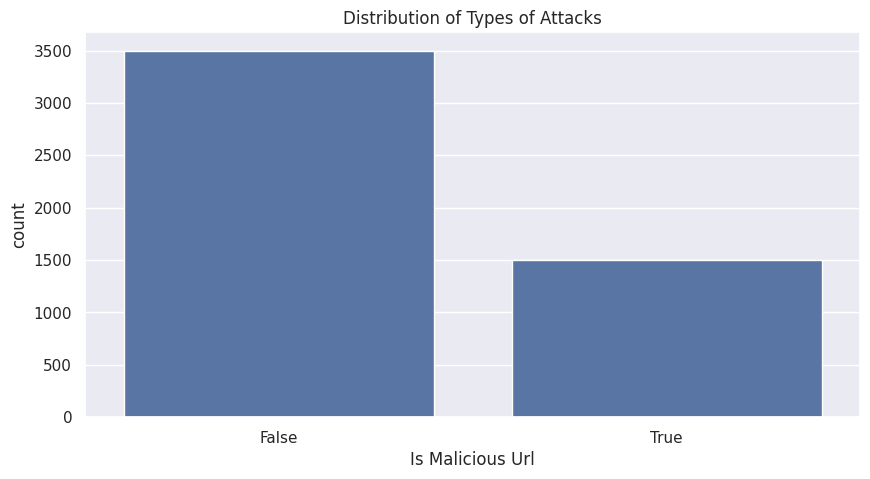

In [265]:
plt.figure(figsize= (10 , 5))
plt.title('Distribution of Types of Attacks')
sns.countplot(x = 'isMalicious', data = df)
# ax.bar_label(ax.containers[0])
plt.xlabel('Is Malicious Url')

plt.savefig(ATTATCH_PATH + '/type_of_accatck.png', bbox_inches='tight')

### WordCloud of url

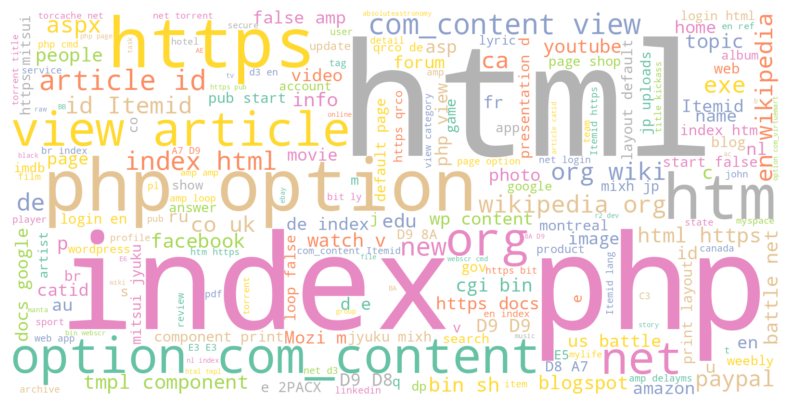

In [266]:
url = " ".join(i for i in df.url)
# print(url[0: 1000])

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",  
    colormap="Set2", 
    
).generate(url)

wordcloud.to_file(ATTATCH_PATH + '/url_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Feature Extraction

### 3.1 IP Address Detection

In [267]:
# Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
print(df['use_of_ip'].value_counts())

use_of_ip
0    4837
1     163
Name: count, dtype: int64


In [268]:
df[df['use_of_ip'] == 1]

,url,type,isMalicious,use_of_ip
2,http://43.156.0.130/v3/signin/identifier?dsh=S...,NaN,False,1
37,http://198.12.66.107/DefaultValueUAxhkNa.exe,malware,True,1
78,http://147.124.215.110/evernew/Newcomo.zip,NaN,False,1
101,http://85.239.33.177/bins/phantom.arm,NaN,False,1
129,http://45.153.34.78/sh4,NaN,False,1
...,...,...,...,...
4932,http://134.122.95.167/bins/bootnoot.x86,malware,True,1
4933,http://45.141.215.37/ppc,NaN,False,1
4935,http://23.238.204.36/m68k,malware,True,1
4977,http://45.125.66.90/LjEZs/uYtea.ppc,NaN,False,1


Text(0.5, 1.0, 'Malsy Gate - Usage of Ip Address')

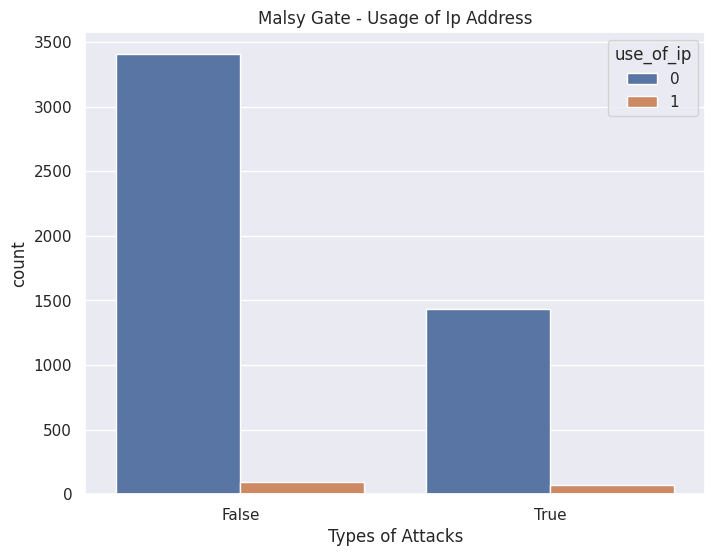

In [269]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="isMalicious", data=df, hue="use_of_ip")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + " - Usage of Ip Address")

**Shape data**

In [270]:
print(df.head())

                                                 url    type  isMalicious  \
0                        peteinfoshare.blogspot.com/  benign        False   
1                              http://106.15.183.184     NaN        False   
2  http://43.156.0.130/v3/signin/identifier?dsh=S...     NaN        False   
3                    youtube.com/watch?v=-WiNbw79hJw  benign        False   
4                                alkond.com/Copy.php  benign        False   

   use_of_ip  
0          0  
1          0  
2          1  
3          0  
4          0  


In [271]:
arr = np.where(df['use_of_ip'] == 1)
arr[0].shape


(163,)

In [272]:
print(arr)

(array([   2,   37,   78,  101,  129,  140,  152,  172,  212,  266,  301,
        330,  380,  420,  453,  461,  495,  527,  569,  698,  723,  724,
        740,  743,  747,  773,  798,  799,  805,  819,  824,  911,  919,
       1016, 1050, 1120, 1127, 1129, 1135, 1143, 1180, 1284, 1292, 1332,
       1395, 1397, 1427, 1583, 1614, 1655, 1737, 1745, 1814, 1822, 1838,
       1864, 1868, 1909, 1914, 1927, 2006, 2023, 2038, 2041, 2078, 2121,
       2155, 2195, 2236, 2243, 2246, 2250, 2297, 2327, 2344, 2348, 2405,
       2424, 2426, 2447, 2460, 2511, 2542, 2583, 2595, 2629, 2673, 2753,
       2772, 2782, 2819, 2913, 2997, 3018, 3023, 3153, 3165, 3200, 3221,
       3239, 3259, 3263, 3281, 3283, 3314, 3324, 3376, 3391, 3451, 3452,
       3468, 3480, 3489, 3494, 3578, 3633, 3650, 3660, 3739, 3814, 3825,
       3846, 3857, 4080, 4085, 4131, 4144, 4158, 4165, 4191, 4198, 4222,
       4231, 4232, 4245, 4246, 4271, 4276, 4283, 4293, 4348, 4350, 4407,
       4439, 4484, 4499, 4504, 4536, 4591, 4596, 4

### 3.2 Abnormal URL

In [273]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:      
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
print(df['abnormal_url'].value_counts())

abnormal_url
0    3086
1    1914
Name: count, dtype: int64


Text(0.5, 1.0, 'Malsy Gate- Usage of Ip Address in domain name in with Diffrent types of attacks')

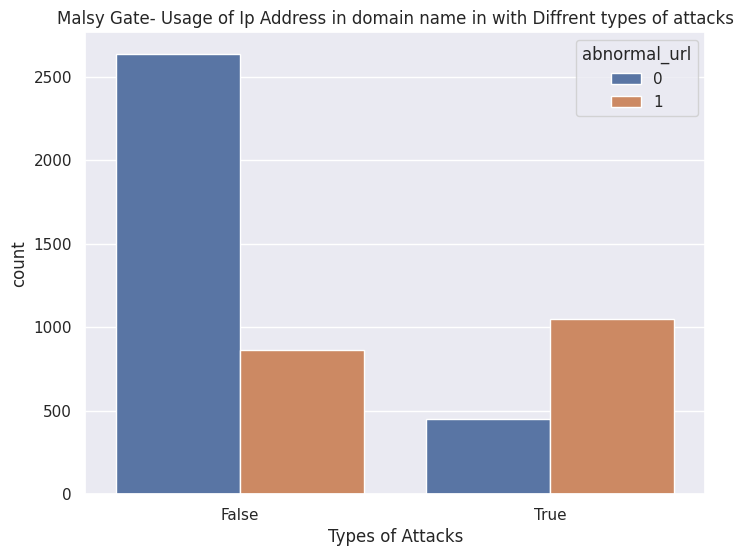

In [274]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="isMalicious", data=df, hue="abnormal_url")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + "- Usage of Ip Address in domain name in with Diffrent types of attacks")

**Shape data**

In [275]:
arr = df['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
0    3086
1    1914
Name: count, dtype: int64


### 3.3 Google Index

In [276]:
def google_index(url):
    
    site = search(url, 5)
    return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [277]:
print(df['url'][0])

for j in search(df['url'][0], num_results=10):
    print(j)

peteinfoshare.blogspot.com/


In [278]:
df['google_index'].value_counts()

google_index
1    5000
Name: count, dtype: int64

### 3.4 Count Features

In [279]:
# Count dot (.)
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count_.'] = df['url'].apply(lambda i: count_dot(i))

# Count www
def count_www(url):
    url.count('www')
    return url.count('www')

df['count_www'] = df['url'].apply(lambda i: count_www(i))

# Count @
def count_atrate(url):
    return url.count('@')

df['count_@'] = df['url'].apply(lambda i: count_atrate(i))

# Count directories
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

# Count embedded domains
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))



Text(0.5, 1.0, 'Malsy Gate - No. Of Dots Available in URLS ')

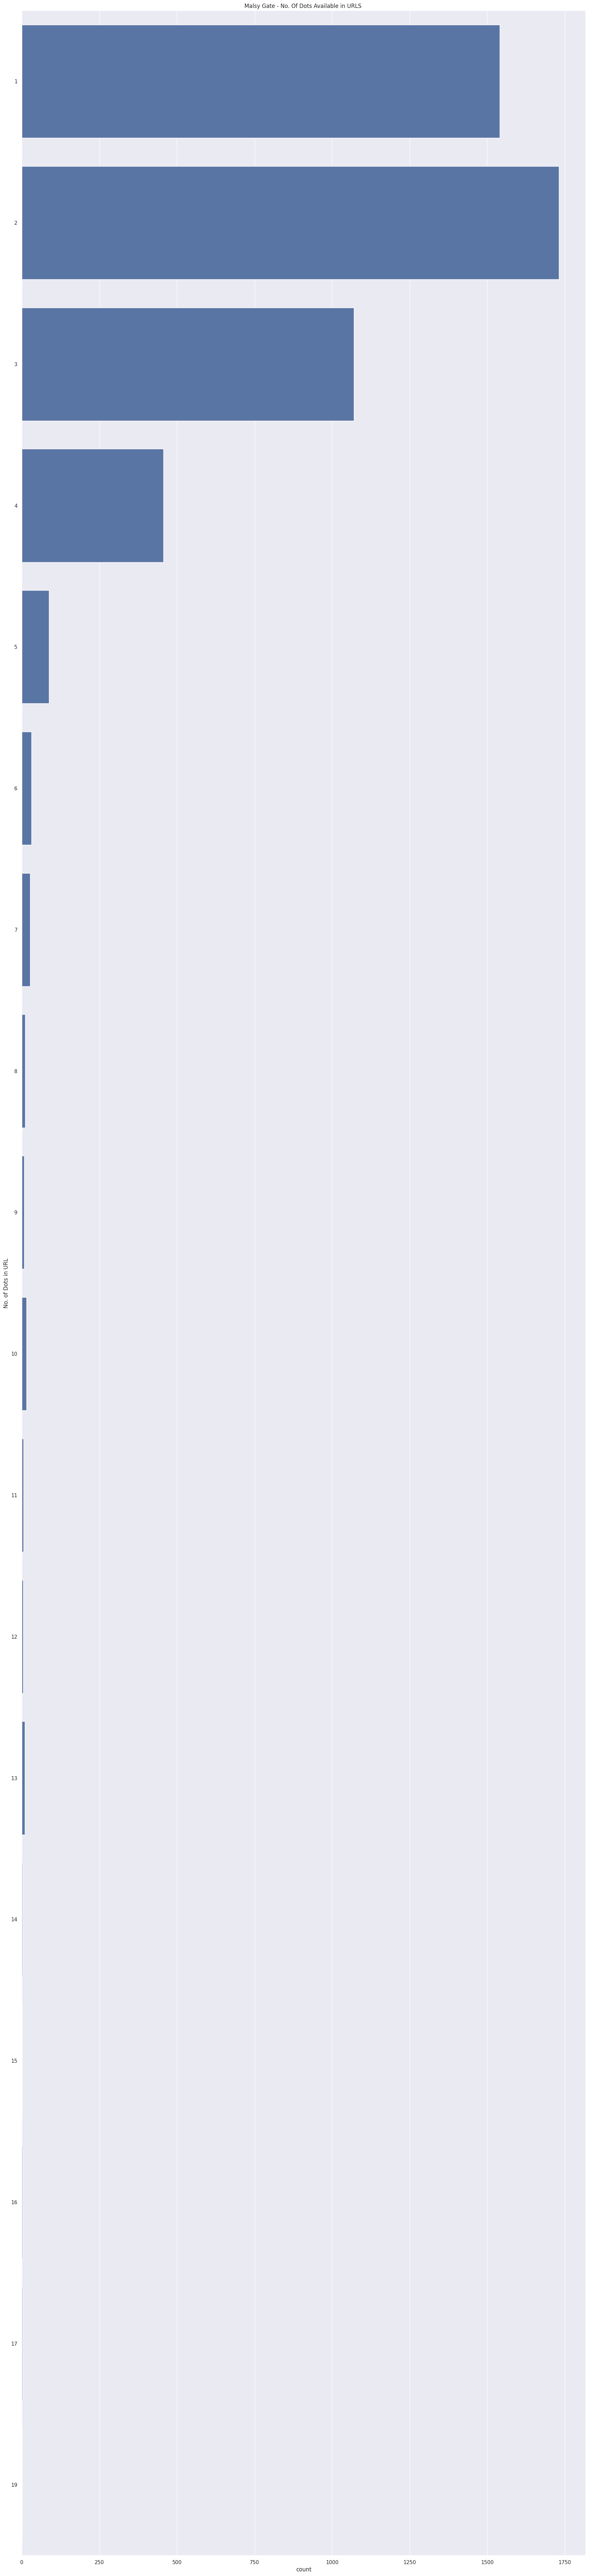

In [280]:
plt.figure(figsize = (22 , 100))
sns.set(style="darkgrid")
ax = sns.countplot(y="count_.", data=df)
plt.ylabel('No. of Dots in URL')
plt.title(APP_NAME + " - No. Of Dots Available in URLS ")

### 3.5 Suspicious Words Detection

In [281]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

### 3.6 URL Shortening Service Detection

In [282]:
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

### 3.7 Protocol Counts

In [283]:
# Count https
def count_https(url):
    return url.count('https')

df['count_https'] = df['url'].apply(lambda i: count_https(i))

# Count http
def count_http(url):
    return url.count('http')

df['count_http'] = df['url'].apply(lambda i: count_http(i))

### 3.8 Special Character Counts

In [284]:
# Count %
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i: count_per(i))

# Count ?
def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

# Count -
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

# Count =
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

### 3.9 Length Features

In [285]:
# URL length
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

# Hostname length
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

### 3.10 Domain Features

In [286]:
# First directory length
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# TLD length
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df = df.drop("tld", axis=1)

### 3.11 Character Counts

In [287]:
# Count digits
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['count_digits'] = df['url'].apply(lambda i: digit_count(i))

# Count letters
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count_letters'] = df['url'].apply(lambda i: letter_count(i))

In [288]:
print(df.head())

                                                 url    type  isMalicious  \
0                        peteinfoshare.blogspot.com/  benign        False   
1                              http://106.15.183.184     NaN        False   
2  http://43.156.0.130/v3/signin/identifier?dsh=S...     NaN        False   
3                    youtube.com/watch?v=-WiNbw79hJw  benign        False   
4                                alkond.com/Copy.php  benign        False   

   use_of_ip  abnormal_url  google_index  count_.  count_www  count_@  \
0          0             0             1        2          0        0   
1          0             1             1        3          0        0   
2          1             1             1        7          0        0   
3          0             0             1        1          0        0   
4          0             0             1        2          0        0   

   count_dir  ...  count%  count?  count-  count=  url_length  \
0          1  ...       0       0

## 4. Label Encoding

In [289]:
# Label Encoding
label_encoder = LabelEncoder()
df['type_code'] = label_encoder.fit_transform(df['isMalicious'])

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

print("\nTarget distribution after encoding:")
print(df['type_code'].value_counts())

Label mapping:
False: 0
True: 1

Target distribution after encoding:
type_code
0    3500
1    1500
Name: count, dtype: int64


## 5. Feature and Target Creation

In [290]:
X = df[['use_of_ip','abnormal_url', 'count_.', 'count_www', 'count_@',
       'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 
       'count-', 'count=', 'url_length', 'count_https', 'count_http', 
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits',
       'count_letters']]

Y = df['type_code']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {Y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

feature_dataset_extraction = pd.concat([df[['url']], X, Y], axis=1)

output_filename = 'feature_dataset_extraction.csv'
feature_dataset_extraction.to_csv(f"{DATA_OUTPUT}/{output_filename}", index=False)

print(f"\nExported the selected features and target to '{output_filename}'")

Feature matrix shape: (5000, 21)
Target vector shape: (5000,)

Features: ['use_of_ip', 'abnormal_url', 'count_.', 'count_www', 'count_@', 'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 'count-', 'count=', 'url_length', 'count_https', 'count_http', 'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits', 'count_letters']

Exported the selected features and target to 'feature_dataset_extraction.csv'


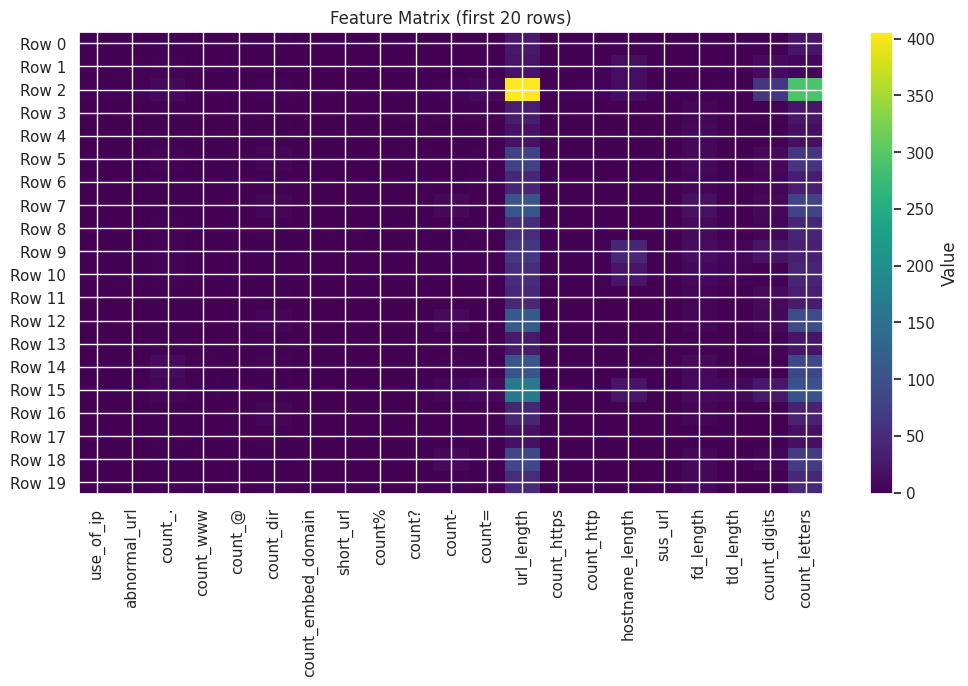

In [291]:
MAXIMUM_ROW=20

plt.figure(figsize=(12,6))
plt.imshow(X.head(MAXIMUM_ROW), aspect='auto', cmap="viridis")
plt.colorbar(label="Value")
plt.yticks(range(MAXIMUM_ROW), [f"Row {i}" for i in range(MAXIMUM_ROW)])
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.title("Feature Matrix (first " + str(MAXIMUM_ROW) +" rows)")
plt.show()

## 6. Cross validation

In [292]:
# X = pd.DataFrame(np.random.rand(100, 4))
# Y = pd.Series(np.random.randint(0, 2, 100))

X = df[['use_of_ip','abnormal_url', 'count_.', 'count_www', 'count_@',
       'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 
       'count-', 'count=', 'url_length', 'count_https', 'count_http', 
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits',
       'count_letters']]

Y = df['type_code']


kfold_model = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_fold(train_index, val_index, X, Y, base_model):
    local_model = clone(base_model)

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

    if len(set(Y_train)) < 2:
        return None  

    local_model.fit(X_train, Y_train)
    y_pred = local_model.predict(X_val)

    return accuracy_score(Y_val, y_pred)

accuracies = Parallel(n_jobs=-1)(
    delayed(evaluate_fold)(train_idx, val_idx, X, Y, SVM_MODEL)
    for train_idx, val_idx in kfold_model.split(X=X, y=Y)
)

# print(accuracies)

accuracies = [acc for acc in accuracies if acc is not None]

print("Accuracies per fold:", accuracies)

if accuracies:
    print("Mean accuracy:", sum(accuracies) / len(accuracies))
else:
    print("No valid folds to compute accuracy.")

Accuracies per fold: [0.809, 0.824, 0.8, 0.779, 0.792]
Mean accuracy: 0.8008000000000001


## 7. Train-Test Split

In [293]:
# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:")
print(Y_train.value_counts())
print(f"\nTest target distribution:")
print(Y_test.value_counts())

Training set size: (4000, 21)
Test set size: (1000, 21)

Training target distribution:
type_code
0    2807
1    1193
Name: count, dtype: int64

Test target distribution:
type_code
0    693
1    307
Name: count, dtype: int64


## 8. Feature Scaling
SVM requires feature scaling for optimal performance.

In [294]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data (using the same scaler fitted on training data)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Feature scaling completed!
Scaled training set shape: (4000, 21)
Scaled test set shape: (1000, 21)


## 9. Training with SVM Model

### Training with SVM Model

In [295]:
# svm_model = SVC(
#     kernel='rbf',
#     C=1.0,
#     probability=True,
#     random_state=42
# )

# svm_model = ThunderSVC(
#     kernel='rbf',
#     C=1.0,
#     # default gpu = 0: primary gpu, 1: secondary gpu
#     gpu_id=0,
#     probability=True,
#     random_state=42
# )

print("Training SVM model...")
print("This may take a few minutes...")
model = SVM_MODEL.fit(X_train_scaled, Y_train)
print("Training complete!")

Training SVM model...
This may take a few minutes...
Training complete!


### Test to predict

In [296]:
# record = 4915
url_to_test = df.sample(1)

print(url_to_test)

                                                    url        type  \
4661  http://www.axelschweizer.de/termine/detail/124...  defacement   

      isMalicious  use_of_ip  abnormal_url  google_index  count_.  count_www  \
4661         True          0             1             1        3          1   

      count_@  count_dir  ...  count?  count-  count=  url_length  \
4661        0          3  ...       1       0       1          77   

      hostname_length  fd_length  tld_length  count_digits  count_letters  \
4661               20          7           2             3             63   

      type_code  
4661          1  

[1 rows x 26 columns]


In [304]:
print(model)


df_to_scale = df[scaler.feature_names_in_]

while True:
    try:
        scaled_data = scaler.transform(df_to_scale)
        break
    except ValueError as e:
        msg = str(e)

        if "Feature names unseen at fit time" in msg:
            start = msg.find("Feature names unseen at fit time:") + len("Feature names unseen at fit time:")
            end = msg.find("\n", start)
            unseen_cols = msg[start:end].strip().replace("-", "").split()
            unseen_cols = [c.strip() for c in unseen_cols if c.strip()]
            print("Removing unused columns:", unseen_cols)
            df_to_scale = df_to_scale.drop(columns=unseen_cols, errors='ignore')
        else:
            raise e

print(scaled_data)

test_result = model.predict(scaled_data)

print(test_result)

SVC(probability=True, random_state=42)
[[-0.18181818 -0.79539491 -0.20169335 ... -0.55415497 -0.5537983
  -0.59918754]
 [-0.18181818  1.25723711  0.45262409 ... -0.55415497  0.38134869
  -1.21594497]
 [ 5.5         1.25723711  3.06989388 ... -0.55415497  4.88705691
   7.63452404]
 ...
 [-0.18181818 -0.79539491 -0.8560108  ... -0.55415497 -0.5537983
  -1.09259348]
 [-0.18181818 -0.79539491 -0.8560108  ... -0.55415497 -0.5537983
  -0.84589051]
 [-0.18181818 -0.79539491 -0.8560108  ... -0.55415497 -0.5537983
  -0.66086329]]
[0 0 0 ... 0 0 0]


## 10. Model Evaluation

In [298]:
# Predictions
Y_pred_train = model.predict(X_train_scaled)
Y_pred_test = model.predict(X_test_scaled)

# Metrics
train_accuracy = accuracy_score(Y_train, Y_pred_train) * 100
test_accuracy = accuracy_score(Y_test, Y_pred_test) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Detailed classification report
print("\n" + "="*50)
print("Classification Report (Test Set)")
print("="*50)

# print(classification_report(Y_test, Y_pred_test, target_names=label_encoder.classes_))

print(classification_report(
    Y_test, 
    Y_pred_test, 
    target_names=[str(c) for c in label_encoder.classes_]
))


Training Accuracy: 89.78%
Test Accuracy: 88.00%

Classification Report (Test Set)
              precision    recall  f1-score   support

       False       0.87      0.97      0.92       693
        True       0.90      0.68      0.78       307

    accuracy                           0.88      1000
   macro avg       0.89      0.82      0.85      1000
weighted avg       0.88      0.88      0.87      1000



## 11. Confusion Matrix

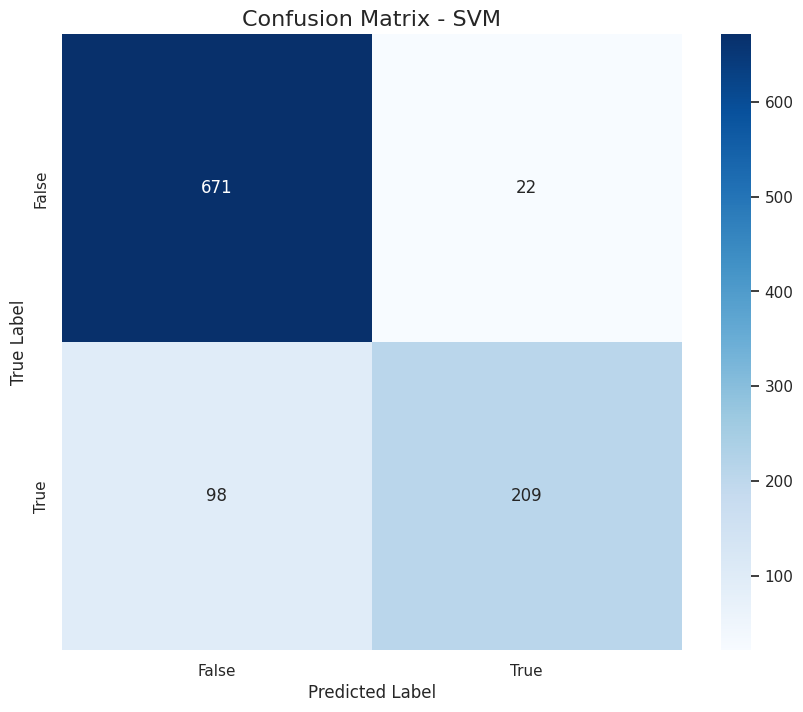

Confusion Matrix:
[[671  22]
 [ 98 209]]


In [299]:
# Create confusion matrix
cm = confusion_matrix(Y_test, Y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

## 12. Model Export

In [ ]:
try:
    # current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model
    model_filename = 'svm_flag_model.pkl'
    joblib.dump(model,  f"{MODEL_PATH}/{model_filename}")
    print(f"Model saved as: {model_filename}")

    # Save the scaler
    scaler_filename = 'svm_flag_scaler.pkl'
    joblib.dump(scaler, f"{MODEL_PATH}/{scaler_filename}")
    print(f"Scaler saved as: {scaler_filename}")

    # Save the label encoder
    encoder_filename = 'label_encoder_svm_flag.pkl'
    joblib.dump(label_encoder, f"{LABLE_PATH}/{encoder_filename}")
    print(f"Label encoder saved as: {encoder_filename}")

    # Save model performance metrics
    metrics = {
        'model': 'SVM',
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'kernel': 'rbf',
        'C': 1.0,
        'random_state': 42
    }

    metrics_filename = 'svm_flag_metrics.json'

    # print(f"{MATRICS_PATH}/{metrics_filename}")

    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{MATRICS_PATH}/{metrics_filename}", index=False)

    print(f"Metrics saved to: svm_flag_metrics.csv")
        
except Exception as e:
    print(e)

Model saved as: svm_flag_model.pkl
Scaler saved as: svm_flag_scaler.pkl
Label encoder saved as: label_encoder_svm_flag.pkl
Metrics saved to: svm_flag_metrics.csv


## 13. Summary

In [301]:
print("="*60)
print("SVM MODEL SUMMARY")
print("="*60)
print(f"Algorithm: Support Vector Machine")
print(f"Kernel: RBF")
print(f"Regularization (C): 1.0")
print(f"Number of Features: {X.shape[1]}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"\nPerformance:")
print(f"  - Training Accuracy: {train_accuracy:.2f}%")
print(f"  - Test Accuracy: {test_accuracy:.2f}%")
print(f"\nModel saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")
print("="*60)

SVM MODEL SUMMARY
Algorithm: Support Vector Machine
Kernel: RBF
Regularization (C): 1.0
Number of Features: 21
Training Samples: 4000
Test Samples: 1000

Performance:
  - Training Accuracy: 89.78%
  - Test Accuracy: 88.00%

Model saved as: svm_flag_model.pkl
Scaler saved as: svm_flag_scaler.pkl
